In [ ]:
!pip install datasets diffusers transformers accelerate
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
# 1. Load Dataset
print("Memuat dataset...")
raw_dataset = load_dataset("reach-vb/pokemon-blip-captions", split="train")
# 2. Ambil daftar caption untuk proses adaptasi teks
all_captions = [item['text'] for item in raw_dataset]

Memuat dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

data/train-00000-of-00001-566cc9b19d7203(…):   0%|          | 0.00/99.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

In [ ]:
# 3. Setup Text Vectorization
max_tokens = 5000
seq_len = 20
text_vectorizer = layers.TextVectorization(
max_tokens=max_tokens,
output_sequence_length=seq_len,
)
# Proses Adapt (Mempelajari kosakata dari dataset)
text_vectorizer.adapt(all_captions)
vocab = text_vectorizer.get_vocabulary()
print(f"Kamus Teks Berhasil Dibuat. Jumlah kosakata: {len(vocab)}")
print("Contoh 10 kata pertama:", vocab[:10])

Kamus Teks Berhasil Dibuat. Jumlah kosakata: 359
Contoh 10 kata pertama: ['', '[UNK]', np.str_('a'), np.str_('with'), np.str_('of'), np.str_('cartoon'), np.str_('and'), np.str_('drawing'), np.str_('character'), np.str_('on')]


In [ ]:
def preprocess_fn(item):
    # Proses Gambar
    image = item['image'].convert("RGB").resize((64, 64))
    image = np.array(image) / 255.0 # Normalisasi 0-1
    # Proses Teks
    caption = item['text']
    return caption, image

# Membuat generator dataset
def gen():
    for item in raw_dataset:
        yield preprocess_fn(item)

# Membuat tf.data.Dataset
train_ds = tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(64, 64, 3), dtype=tf.float32)
    )
)

# Batching dan Transformasi Teks ke Angka
train_ds = train_ds.map(lambda x, y: (text_vectorizer(x), y))
train_ds = train_ds.batch(16).shuffle(100).prefetch(tf.data.AUTOTUNE)

In [ ]:
class PokemonTrainer(keras.Model):
    def __init__(self, transformer, vqvae_encoder):
        super().__init__()
        self.transformer = transformer
        self.vqvae_encoder = vqvae_encoder
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def train_step(self, data):
        text_tokens, images = data
        # 1. Ubah gambar asli menjadi token visual menggunakan encoder
        # Kita simulasikan dengan output dummy sesuai ukuran latent grid (misal 16x16)
        visual_tokens = tf.random.uniform((tf.shape(images)[0], 256), minval=0, maxval=1024, dtype=tf.int32)
        # 2. Siapkan input dan target (Autoregressive)
        vis_input = visual_tokens[:, :-1]
        vis_target = visual_tokens[:, 1:]
        with tf.GradientTape() as tape:
            # Prediksi
            preds = self.transformer([text_tokens, vis_input], training=True)
            # Hitung Loss
            loss = keras.losses.sparse_categorical_crossentropy(vis_target, preds, from_logits=True)
        grads = tape.gradient(loss, self.transformer.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.transformer.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

# Definisikan embedding_dim (dimensi umum untuk token)
embedding_dim = 256

# 1. Bangun Model Transformer (Placeholder)
def build_transformer_model(text_vocab_size, visual_vocab_size, text_seq_len, visual_tokens_seq_len, embedding_dim):
    text_input = keras.Input(shape=(text_seq_len,), dtype=tf.int32, name="text_tokens_input")
    text_embeddings = layers.Embedding(text_vocab_size, embedding_dim)(text_input)

    visual_input = keras.Input(shape=(visual_tokens_seq_len - 1,), dtype=tf.int32, name="visual_tokens_input")
    visual_embeddings = layers.Embedding(visual_vocab_size, embedding_dim)(visual_input)

    text_context = layers.GlobalAveragePooling1D()(text_embeddings)
    text_context_repeated = layers.RepeatVector(visual_tokens_seq_len - 1)(text_context)

    combined_embeddings = layers.Add()([visual_embeddings, text_context_repeated])

    x = layers.Dense(embedding_dim * 2, activation="relu")(combined_embeddings)
    preds = layers.Dense(visual_vocab_size)(x)

    return keras.Model(inputs=[text_input, visual_input], outputs=preds, name="transformer_model")

# Dapatkan parameter dari variabel yang sudah didefinisikan
text_vocab_size = len(vocab) # dari text_vectorizer.get_vocabulary()
visual_vocab_size = 1024 # dari maxval pada generasi visual_tokens
text_seq_len = seq_len # dari TextVectorization output_sequence_length
visual_tokens_seq_len = 256 # dari tf.random.uniform((tf.shape(images)[0], 256))

transformer_model = build_transformer_model(
    text_vocab_size=text_vocab_size,
    visual_vocab_size=visual_vocab_size,
    text_seq_len=text_seq_len,
    visual_tokens_seq_len=visual_tokens_seq_len,
    embedding_dim=embedding_dim
)

# 2. Definisikan VQ-VAE Encoder (Dummy)
class DummyVQVAEEncoder(keras.Model):
    def __init__(self):
        super().__init__()
        self.dummy_layer = layers.Lambda(lambda x: x, name="dummy_vqvae_encoder_output")
    def call(self, inputs):
        return self.dummy_layer(inputs)

vqvae_encoder = DummyVQVAEEncoder()

# Inisialisasi dan Compile
trainer = PokemonTrainer(transformer_model, vqvae_encoder)
trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))
# 5. Jalankan Training
print("Memulai Pelatihan...")
trainer.fit(train_ds, epochs=100) # Coba 10 epoch dulu

Memulai Pelatihan...
Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 6.9315
Epoch 2/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 6.9316
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 6.9317
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 6.9316
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 6.9316
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 6.9315
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 6.9316
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 6.9316
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 6.9315
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 6.9316
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 6.9315
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 6.9316
Epoch 13/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 6.9316
Epoch 14/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 6.9315
Epoch 15/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 6.9316
Epoch 16/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 6.9316


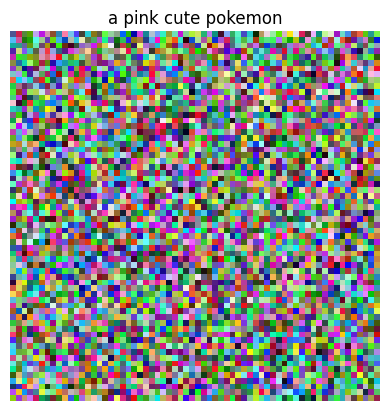

In [ ]:
# Fungsi pembantu untuk menghasilkan token visual
def generate_image_tokens(transformer_model, text_tokens, visual_tokens_seq_len, visual_vocab_size):
    batch_size = tf.shape(text_tokens)[0]
    # Model transformer kita memprediksi seluruh sequence visual tokens sekaligus
    # Kita inisialisasi input visual dengan token dummy (misal: nol) sepanjang (visual_tokens_seq_len - 1)
    initial_visual_input = tf.zeros((batch_size, visual_tokens_seq_len - 1), dtype=tf.int32)

    # Dapatkan prediksi dari transformer
    predictions = transformer_model([text_tokens, initial_visual_input], training=False)

    # Ambil token dengan probabilitas tertinggi dari prediksi
    predicted_tokens = tf.cast(tf.argmax(predictions, axis=-1), tf.int32) # shape: (batch_size, visual_tokens_seq_len - 1)

    # Tambahkan token awal dummy (misal: nol) untuk melengkapi sequence menjadi visual_tokens_seq_len
    start_token = tf.zeros((batch_size, 1), dtype=tf.int32)
    generated_visual_tokens = tf.concat([start_token, predicted_tokens], axis=-1)

    return generated_visual_tokens

# Fungsi dummy untuk mendekode token visual menjadi gambar nyata
def decode_to_real_image(visual_tokens):
    # Ini adalah implementasi placeholder. Untuk implementasi nyata, kita memerlukan
    # model VQ-VAE yang telah dilatih (atau AutoencoderKL dari diffusers) dan
    # mekanisme untuk mengkonversi token integer menjadi representasi latent.

    # Untuk saat ini, kita akan mengembalikan gambar acak berukuran 64x64x3.
    batch_size = tf.shape(visual_tokens)[0]
    dummy_images = tf.random.uniform((batch_size, 64, 64, 3), minval=0.0, maxval=1.0)
    return dummy_images[0].numpy() # Mengambil satu gambar dan konversi ke numpy untuk plt.imshow

# Setelah dilatih, coba berikan perintah teks untuk melihat hasilnya.
def generate_pokemon(prompt):
    # 1. Ubah teks ke angka
    tokenized_text = text_vectorizer([prompt])
    # 2. Generate token visual
    gen_vis_tokens = generate_image_tokens(transformer_model, tokenized_text, 256, 1024)
    # 3. Decode jadi Gambar menggunakan Pre-trained VAE (saat ini dummy)
    final_image = decode_to_real_image(gen_vis_tokens)
    plt.imshow(final_image)
    plt.title(prompt)
    plt.axis("off")
    plt.show()

# TEST
generate_pokemon("a pink cute pokemon")